# Learning Branch and Bound Optimization

In this notebook, you will learn how to drastically improve the performance of a naive branch and bound algorithm by helping it make better decisions on how to explore the search space. We will use the Knapsack Problem as an example, but the concepts can be applied to many other problems.

During this, you will learn about many techniques employed by commercial solvers.
In the end, only experts will be able to beat the performance of generic solvers such as Gurobi or CP-SAT by implementing their own branch and bound algorithm. However, understanding the concepts behind these algorithms is very important to be able to use these solvers effectively.
Using visualizations, you will see how the algorithm works and explore the impact of different strategies on the performance of the algorithm.

The Branch and Bound algorithm was taught in Algorithms and Data Structures 2. If you did not attend this class or need a refresher, you can check the following resources:

* [15min Video by the amazing Pascal van Hentenryck](https://www.coursera.org/lecture/discrete-optimization/knapsack-5-relaxation-branch-and-bound-66OlO?utm_source=link&utm_medium=page_share&utm_content=vlp&utm_campaign=top_button)

In [ ]:
# Let us first implement the predefined elements.
# You can find the concrete code in the subfolder.
# Do check it out, you need to unstand them to execute the tasks.
import typing

from knapsack_bnb import (
    BnBNode,
    BnBSearch,
    BranchingDecisions,
    BranchingStrategy,
    FractionalSolution,
    Heuristics,
    Instance,
    Item,
    RelaxationSolver,
    SearchStrategy,
)

## Relaxation

The first key concept of the branch and bound algorithm is the relaxation of the problem.
The relaxation is a simplified version of the problem that can be solved more easily.
The solution of the relaxation is used to guide the search of the branch and bound algorithm.

For the Knapsack Problem, the relaxation is the fractional knapsack problem.
Here, we can take fractions of the items, so we can use a greedy algorithm to solve it.
The greedy algorithm has been shown to be optimal for the fractional knapsack problem.

It is extremely important that the relaxation algorithm is (super-)optimal, i.e., it always returns the best solution for the relaxation problem.
The relaxation problem needs to contain the original problem, in especially, the optimal solution for the original problem needs to be a valid solution for the relaxation problem.
The closer the relaxation problem is to the original problem, the better the branch and bound algorithm will perform.

Due to the later branching, the relaxation needs to be able to deal with the branching decisions.
For the Knapsack Problem, we give it a set of mandatory and prohibited items that have been decided by the branch and bound algorithm.
The relaxation algorithm needs to be able to solve the fractional knapsack problem with these constraints.
As it essentially just reduces the original instance by removing the prohibited items and removing the mandatory items from the remaining capacity, this is an easy task.

Below, you find the implementation of the fractional knapsack problem, but it still can be improved.
Can you find a way to *strengthen* the relaxation, i.e., make it closer to the integral solution without loosing integral solutions?
Are there any items you know cannot be part of the solution, but could be part of the relaxation, essentially weakening it?

In [ ]:
class MyRelaxationSolver(RelaxationSolver):
    """
    Solve the fractional knapsack problem from the given instance and branching
    decisions.
    """

    def solve(
        self, instance: Instance, fixation: BranchingDecisions
    ) -> FractionalSolution:
        """
        Solve the fractional knapsack problem from the given instance and deduced
          fixations.
        instance: knapsack problem instance
        fixation: list of predefined item selections, where 0 means not taken,
            1 means fully taken, and None means not fixed
        """
        remaining_capacity = instance.capacity - sum(
            item.weight for item, x in zip(instance.items, fixation) if x == 1
        )
        # Compute solution
        selection = [1.0 if x == 1 else 0.0 for x in fixation]
        remaining_indices = [i for i, x in enumerate(fixation) if x is None]
        remaining_indices.sort(
            key=lambda i: instance.items[i].value / instance.items[i].weight,
            reverse=True,
        )
        for i in remaining_indices:
            # Fill solution with items sorted by value/weight
            if instance.items[i].weight <= remaining_capacity:
                selection[i] = 1.0
                remaining_capacity -= instance.items[i].weight
            else:
                selection[i] = remaining_capacity / instance.items[i].weight
                break  # no capacity left
        assert all(
            x0 == x1 for x0, x1 in zip(fixation, selection) if x0 is not None
        ), "Fixed part is not allowed to change."
        return FractionalSolution(instance, selection)

## Heuristics

The relaxation directly gives us a bound on the solution quality.
In this case, it is an upper bound.
No solution obeying the branching decisions can be better than the solution of the relaxation.

Having a lower bound is very important during the search.
If we are in a node and the upper bound, i.e., relaxation, for this branch is worse than the best solution found so far, we can prune the branch, potentially saving a lot of time.
Instead of waiting until we find a node with an integral solution, we can directly try to find an integral solution from the relaxation.
This may not be a good one, but can still help us to prune branches.

The following implementation just checks if the node has a feasible integral solution.
However, we can do better and also return feasible integral solutions from non-integral solutions...


In [ ]:
class MyHeuristic(Heuristics):
    def __init__(self):
        super().__init__()

    def search(
        self, instance: Instance, node: BnBNode
    ) -> typing.Generator[FractionalSolution, None, None]:
        # Maybe we can also obtain a feasible solution from fractional solutions?
        # It doesn't have to be perfect...
        if (
            node.relaxed_solution.is_fractionally_feasible()
            and node.relaxed_solution.is_integral()
        ):
            # WARNING: Do not not modify the solution in place! Create a copy!
            yield node.relaxed_solution.copy()

## Search Strategy

Stronger relaxations and better heuristics will already improve the lower and upper bounds and thus the performance of the branch and bound algorithm.
However, the search strategy is also very important.
The search strategy decides which nodes to explore first.
During the search, the branch and bound algorithm will create a tree of nodes, where each node represents a partial solution.
This tree will quickly grow and there are many ways to explore it.
As during the exploration, we will improve lower and upper bounds, the order of the exploration can have a big impact on the performance.
A simple breadth-first or depth-first search may not be the best choice as these are oblivious to the quality of the nodes.

Which node would you explore next if your goal is to improve the lower or upper bound as quickly as possible?

In [ ]:
# The node with the smallest priority value is selected first.
# If two nodes have the same priority value, the one that was created first is selected first.
# Maybe there is a better way than to do a first in first out?
def my_search_order(node: BnBNode):
    # The returned value must be comparable.
    # It can be a number, a tuple, or any other comparable object.
    # If my_search_order(a)<my_search_order(b), then a is selected first.
    return 1

## Branching Strategy

If your search strategy returns a node with a non-integral solution, you need to decide how to branch the solution space.
The branching strategy decides how to create the children of a node and effectively splits the solution space into smaller parts.
The branching strategy can have a big impact on the performance of the branch and bound algorithm.
Often, the branching happens only on a single variable, e.g., we create two children by fixing a variable to 0 (False) and 1 (True).
The left child will then further explore the solution space where the variable is 0 and the right child will further explore the solution space where the variable is 1.
As we know that the optimal solution is integral, i.e., will not have a value of 0.3, it still has to be in one of the children.
For non-boolean variable, the branching is slightly more complicated (requiring <=0 and >=1, to still allow 2 as a value), but for the Knapsack Problem, we can simply branch on =0 and =1.

The naive implementation will always branch on the first not yet fixed variable, i.e., item to be included or not.
However, you may have a better strategy to decide which variable to branch on by looking at the branch and bound tree....

In [ ]:
class MyBranchingStrategy(BranchingStrategy):
    """
    Implementation of BranchingStrategy that branches on the first (min index) non-integer variable.
    """

    def make_branching_decisions(
        self, fractional_node: BnBNode
    ) -> typing.Iterable[BranchingDecisions]:
        """
        You are given a node with a fractional solution. Decide how you want to split the
        solution space. The easiest way to do so is to select a variable that hasn't been fixed
        yet and split the solution space into two by fixing it to 0 and 1, respectively.
        """
        assert not fractional_node.relaxed_solution.is_integral(), "Node is fractional"
        assert (
            fractional_node.relaxed_solution.is_fractionally_feasible()
        ), "Node is feasible"
        # find the index of the first non-fixed variable
        first_unfixed_idx = min(
            i for i, x in enumerate(fractional_node.branching_decisions) if x is None
        )
        yield from fractional_node.branching_decisions.split_on(first_unfixed_idx)

## Solve the Knapsack Problem!

The following cells give you some instances and some targets to reach.
Improve the code above until all assertions pass.
Every execution will create an `output.html` which visualize the branch and bound tree for you to understand the impact of your changes.


Below you can see an example of the visualization.
Left is the root node with the corresponding value of the relaxation as node label.
You can see how it branches into two children, which again branch into two children.
Infeasible nodes are marked red, while feasible integral solutions are marked green.
By using the slider, you can see the progress over time.

**You may need to 'trust' the html in order for the javascript to work.**

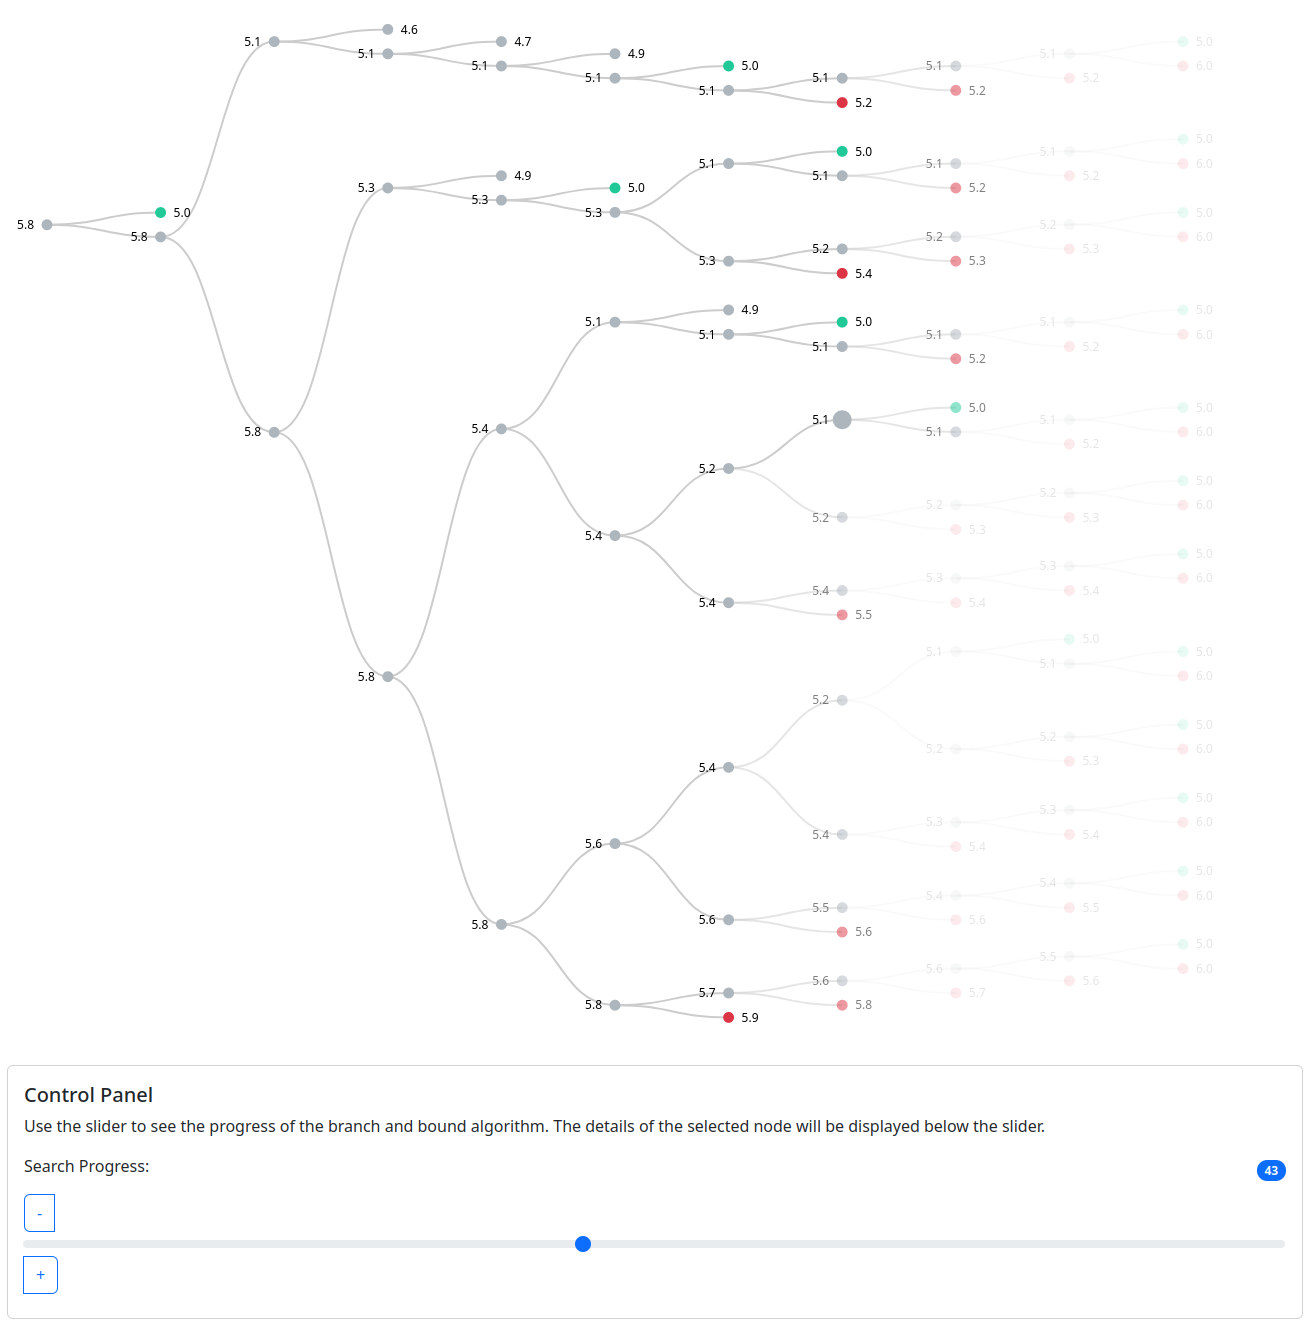

In [ ]:
instance = Instance(
    items=[
        Item(weight=1, value=1),
        Item(weight=2, value=1),
        Item(weight=3, value=1),
        Item(weight=4, value=1),
        Item(weight=5, value=1),
        Item(weight=6, value=1),
        Item(weight=7, value=1),
        Item(weight=8, value=1),
        Item(weight=9, value=1),
        Item(weight=10, value=1),
    ],
    capacity=20,
)


bnb = BnBSearch(
    instance,
    relaxation=MyRelaxationSolver(),
    search_strategy=SearchStrategy(priority=my_search_order),
    branching_strategy=MyBranchingStrategy(),
    heuristics=MyHeuristic(),
)

bnb.search()
assert bnb.progress_tracker.upper_bound() == 5
assert bnb.progress_tracker.lower_bound() == 5
assert (
    bnb.progress_tracker.num_iterations <= 200
), "You should not need more than 200 iterations."
assert bnb.progress_tracker.num_iterations <= 50, "Try to get below 50 iterations!"

In [ ]:
instance = Instance(
    items=[
        Item(weight=1, value=10),
        Item(weight=2, value=10),
        Item(weight=3, value=10),
        Item(weight=4, value=10),
        Item(weight=5, value=10),
        Item(weight=6, value=10),
        Item(weight=7, value=10),
        Item(weight=8, value=10),
        Item(weight=9, value=10),
        Item(weight=10, value=10),
        Item(weight=11, value=20),
        Item(weight=12, value=30),
    ],
    capacity=20,
)


bnb = BnBSearch(
    instance,
    relaxation=MyRelaxationSolver(),
    search_strategy=SearchStrategy(priority=my_search_order),
    branching_strategy=MyBranchingStrategy(),
    heuristics=MyHeuristic(),
)

bnb.search()
assert bnb.progress_tracker.upper_bound() == 60
assert bnb.progress_tracker.lower_bound() == 60
assert (
    bnb.progress_tracker.num_iterations <= 200
), "You should not need more than 200 iterations."
assert bnb.progress_tracker.num_iterations <= 10, "Try to get below 10 iterations!"

In [ ]:
instance = Instance(
    items=[
        Item(weight=1, value=10),
        Item(weight=3, value=15),
        Item(weight=5, value=7),
        Item(weight=7, value=22),
        Item(weight=9, value=13),
        Item(weight=11, value=17),
        Item(weight=13, value=9),
        Item(weight=15, value=27),
        Item(weight=17, value=16),
        Item(weight=19, value=21),
        Item(weight=21, value=29),
        Item(weight=23, value=30),
        Item(weight=25, value=25),
        Item(weight=27, value=31),
        Item(weight=29, value=18),
        Item(weight=31, value=33),
        Item(weight=33, value=20),
        Item(weight=35, value=35),
        Item(weight=37, value=23),
        Item(weight=39, value=37),
    ],
    capacity=100,
)


bnb = BnBSearch(
    instance,
    relaxation=MyRelaxationSolver(),
    search_strategy=SearchStrategy(priority=my_search_order),
    branching_strategy=MyBranchingStrategy(),
    heuristics=MyHeuristic(),
)
bnb.search()
assert bnb.progress_tracker.upper_bound() == 171
assert bnb.progress_tracker.lower_bound() == 171
assert (
    bnb.progress_tracker.num_iterations <= 200
), "You should not need more than 200 iterations."
assert bnb.progress_tracker.num_iterations <= 30, "Try to get below 30 iterations!"